<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/NLP/DZ_4_QA_bert_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question answering. Практическое задание (PJ)

Для закрепления материала модуля предлагаем вам решить задачу QA для датасета [SberQuad](https://huggingface.co/datasets/sberquad), используя любые доступные вам средства.

Для достижения наилучшего результата уделите внимание подбору гиперапарметров как в плане архитектуры, так и в плане обучения модели.

Критерии оценивания проекта:

- общее качество кода и следование PEP-8;
- использование рекуррентных сетей;
- использованы варианты архитектур, близкие к state of the art для данной задачи;
- произведен подбор гиперпараметров;
- использованы техники изменения learning rate (lr scheduler);
- использована адекватная задаче функция потерь;
- использованы техники регуляризации;
- корректно проведена валидация модели;
- использованы техники ensemble;
- использованы дополнительные данные;
- итоговое значение метрики качества > 0.75 (f1).


In [1]:
!pip install datasets evaluate transformers[sentencepiece] -q
!pip install accelerate -q
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 4.3 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
git-lfs is already the newest versio

# Load_dataset

In [2]:
from datasets import load_dataset

raw_datasets = load_dataset("sberquad")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/45328 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5036 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/23936 [00:00<?, ? examples/s]

In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 45328
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5036
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 23936
    })
})

In [4]:
print("Context: ", raw_datasets["train"][0]["context"])
print("Question: ", raw_datasets["train"][0]["question"])
print("Answer: ", raw_datasets["train"][0]["answers"])

Context:  В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий.
Question:  чем представлены органические остатки?
Answer:  {'text': ['известковыми выделениями сине-зелёных водорослей'], 'answer_start': [109]}


In [5]:
set(raw_datasets["train"]["title"])

{'SberChallenge'}

In [6]:
raw_datasets["train"]["context"][0]

'В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий.'

In [7]:
raw_datasets["train"]["question"][0]

'чем представлены органические остатки?'

In [8]:
raw_datasets["train"]["answers"][0]#["text"]

{'text': ['известковыми выделениями сине-зелёных водорослей'],
 'answer_start': [109]}

Check datasent onto answers not equal 1

In [9]:
raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

Filter:   0%|          | 0/45328 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

In [10]:
print(raw_datasets["validation"][0]["answers"])
print(raw_datasets["validation"][2]["answers"])

{'text': ['в Древнем Египте'], 'answer_start': [60]}
{'text': ['COSTAR'], 'answer_start': [187]}


In [11]:
print(raw_datasets["validation"][2]["context"])
print(raw_datasets["validation"][2]["question"])

Телескоп имеет модульную структуру и содержит пять отсеков для оптических приборов. Один из отсеков в течение долгого времени (1993—2009 годы) занимала корректирующая оптическая система (COSTAR), установленная во время первой экспедиции обслуживания в 1993 году для компенсации неточности изготовления главного зеркала. Поскольку все приборы, установленные после запуска телескопа, имеют встроенные системы коррекции дефекта, во время последней экспедиции стало возможно демонтировать систему COSTAR и использовать отсек для установки ультрафиолетового спектрографа.
Как называется корректирующая оптическая система, установленная на телескоп во время первой экспедиции обслуживания в 1993 году для компенсации неточности изготовления главного зеркала?


# Tokenizer

In [12]:
from transformers import AutoTokenizer

model_checkpoint = "timpal0l/mdeberta-v3-base-squad2" # "distilbert-base-cased-distilled-squad" #
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
context = raw_datasets["train"][0]["context"]
question = raw_datasets["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'[CLS] чем представлены органические остатки?[SEP] В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий.[SEP]'

In [14]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] чем представлены органические остатки?[SEP] В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого веществ[SEP]
[CLS] чем представлены органические остатки?[SEP]ёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли,[SEP]
[CLS] чем представлены органические остатки?[SEP]ятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и фо

In [15]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [16]:
inputs["overflow_to_sample_mapping"]

[0, 0, 0, 0]

In [17]:
inputs = tokenizer(
    raw_datasets["train"][2:6]["question"],
    raw_datasets["train"][2:6]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 20 features.
Here is where each comes from: [0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3].


In [18]:
answers = raw_datasets["train"][2:6]["answers"]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions

([22, 0, 0, 0, 0, 65, 33, 0, 0, 0, 72, 37, 0, 0, 67, 33, 0, 0, 0, 0],
 [25, 0, 0, 0, 0, 74, 42, 0, 0, 0, 82, 47, 0, 0, 72, 38, 0, 0, 0, 0])

In [19]:
idx = 0
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")

Theoretical answer: органические остатки, labels give: органические остатки


In [20]:
idx = 1
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

decoded_example = tokenizer.decode(inputs["input_ids"][idx])
print(f"Theoretical answer: {answer}, decoded example: {decoded_example}")

Theoretical answer: органические остатки, decoded example: [CLS] что встречается в протерозойских отложениях?[SEP] сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найд[SEP]


# Take rand_part datasets

In [25]:
import numpy as np

In [26]:
i =  2167
raw_datasets["validation"][i] , raw_datasets["test"][i]

({'id': 76422,
  'title': 'SberChallenge',
  'context': 'Относительно вхождения уральской семьи языков в более крупные генетические объединения существуют разные гипотезы, ни одна из которых не признана специалистами по уральским языкам. Согласно ностратической гипотезе, уральская семья, наряду с другими языковыми семьями и макросемьями входит в состав более крупного образования — ностратической макросемьи, причём сближается там с юкагирскими языками, образуя уральско-юкагирскую группу. Данная позиция, однако, была подвергнута критике различными специалистами, считается весьма спорной и её выводы не принимаются многими компаративистами, которые рассматривают теорию ностратических языков либо как, в худшем случае, полностью ошибочную или как, в лучшем случае, просто неубедительную[8][9]. Примерно до середины 1950-х гг. была популярна урало-алтайская гипотеза, объединявшая в одну макросемью уральские и алтайские языки, однако в настоящее время она не пользуется поддержкой лингвистов. С у

In [27]:
part_of_data = 0.1

set_ids = np.random.choice(range(len(raw_datasets["validation"])), int(len(raw_datasets["validation"])*part_of_data*2.2), replace=False)
len(set_ids)

1107

In [28]:
choice = np.random.choice(range(len(set_ids)), int(len(set_ids)*0.2), replace=False)
test_mask = np.zeros(set_ids.shape[0], dtype=bool)
test_mask[choice] = True

test_ids = set_ids[test_mask]
val_ids = set_ids[~test_mask]
len(val_ids), len(test_ids)

(886, 221)

In [59]:
from datasets import Dataset, DatasetDict

part_of_data = 0.1

DATASETS = DatasetDict({
    'train': raw_datasets["train"].select(
            np.random.choice(range(len(raw_datasets["train"])), int(len(raw_datasets["train"])*part_of_data), replace=False)
        ),
    'validation': raw_datasets["validation"].select(val_ids
        ),
    'test': raw_datasets["validation"].select(test_ids
        )
})

DATASETS

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 4532
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 886
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 221
    })
})

In [60]:
DATASETS['test'][100]

{'id': 60545,
 'title': 'SberChallenge',
 'context': 'В связи с ростом международной торговли интерес к каналу ожил к началу XIX века; в 1814 году Испания приняла закон об устройстве междуокеанского канала; в 1825 году аналогичное решение принимает конгресс центрально-американских государств. Открытие месторождений золота в Калифорнии вызвало в США повышенный интерес к проблеме канала, и в 1848 году США по договору Хейса получили в Никарагуа монопольное право на постройку всех видов междуокеанских путей сообщения. Великобритания, чьи владения соприкасались с Никарагуа, поспешила обуздать экспансию США, заключив с ними 18 апреля 1850 году Договор Клейтона — Булвера о совместной гарантии нейтралитета и безопасности будущего междуокеанского канала. В течение всего XIX века рассматривались два основных варианта направления канала: через Никарагуа (см. Никарагуанский канал) и через Панаму.[4]',
 'question': 'Когда начал проявляться интерес к Панамскому каналу?',
 'answers': {'text': ['к нач

# Как в данном случае можно сформировать метки классов?

Обычно поступают так: для каждого токена мы имеем два бинарных класса, является данный токен началом ответа или его окончанием. Выглядит это следующим образом:

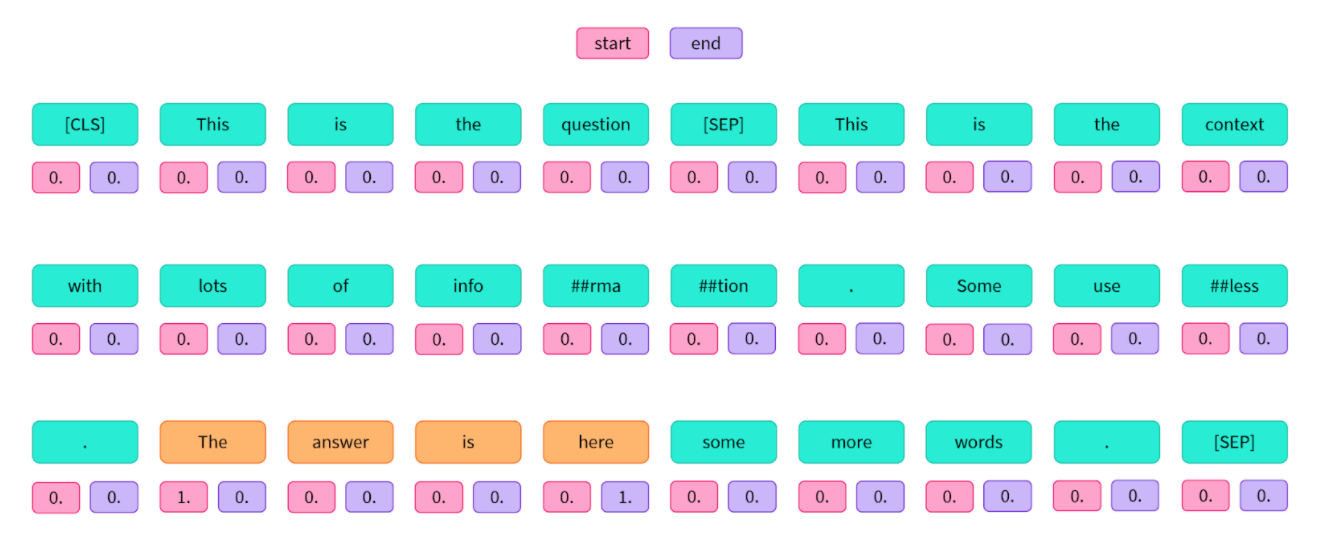

## Обработку данных можно провести следующим образом:

## Preprocess_training_examples

In [30]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

#



Из представленного кода мы можем получить:

- (0, 0), если ответ находится за границами рассматриваемого контекста.
- (start_position, end_position) — в противном случае, при этом start_position является индекс токена начала ответа, а end_position — индекс токена окончания ответа.

Обучающее множество можно подготовить следующим образом:

In [31]:
train_dataset = DATASETS["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=DATASETS["train"].column_names,
)
len(DATASETS["train"]), len(train_dataset)

Map:   0%|          | 0/4532 [00:00<?, ? examples/s]

(4532, 4763)

## Preprocess_validation_examples
Для валидационного и тестового датасетов описанная выше функция немного изменяется из-за того, что нам нет необходимости формировать метки классов для токенов.

In [32]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

Применим эту функцию к валидационному датасету:

In [33]:
validation_dataset = DATASETS["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=DATASETS["validation"].column_names,
)

Map:   0%|          | 0/886 [00:00<?, ? examples/s]

# Model

In [34]:
import torch
from transformers import AutoModelForQuestionAnswering

In [35]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

In [36]:
model_name = model_checkpoint.split('/')[1] +"-sberquad" #
output_dir = "/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/NLP_course/DZ/Question_Answering/Model"

In [37]:
model_name

'mdeberta-v3-base-squad2-sberquad'

In [38]:
small_eval_set = raw_datasets["validation"].select(range(100))

eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [39]:
eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}

with torch.no_grad():
    outputs = model(**batch)

In [40]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

In [41]:
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

for example in small_eval_set:
    example_id = example["id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": str(example_id), "prediction_text": best_answer["text"]})

In [42]:
theoretical_answers = [
    {"id": str(ex["id"]), "answers": ex["answers"]} for ex in small_eval_set
]

In [43]:
print(predicted_answers[0])
print(theoretical_answers[0])

{'id': '60544', 'prediction_text': ' Древнем Египте'}
{'id': '60544', 'answers': {'text': ['в Древнем Египте'], 'answer_start': [60]}}


# DataLoader_data_collator

In [44]:
from torch.utils.data import DataLoader
from transformers import default_data_collator
BATCH_SIZE = 1
train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=BATCH_SIZE,
)

eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=BATCH_SIZE
)

# Compute_metrics

Качество решения данной задачи, как и в случае sequence tagging, обычно оценивают с помощью F₁-меры. Для корректного подсчёта метрики нужно произвести небольшую постобработку результатов модели, как это показано в следующей функции:

In [45]:
import evaluate

metric = evaluate.load("squad")

In [46]:
N_BEST = 20
MAX_ANSW_LEN = 30

In [47]:
from tqdm.auto import tqdm
import collections

def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -N_BEST - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -N_BEST - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > MAX_ANSW_LEN
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": str(example_id), "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": str(ex["id"]), "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

# Train model

In [48]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [49]:
from accelerate import Accelerator

accelerator = Accelerator()#fp16=True)
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [50]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [51]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, DATASETS["validation"]
    )
    print(f"epoch {epoch}:", metrics)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        #repo.push_to_hub(
      #      commit_message=f"Training in progress epoch {epoch}", blocking=False
      # )

  0%|          | 0/14289 [00:00<?, ?it/s]

Evaluation!


  0%|          | 0/927 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

epoch 0: {'exact_match': 66.2528216704289, 'f1': 85.69034649994137}
Evaluation!


  0%|          | 0/927 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

epoch 1: {'exact_match': 67.94582392776523, 'f1': 85.82498026772214}
Evaluation!


  0%|          | 0/927 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

epoch 2: {'exact_match': 65.68848758465012, 'f1': 83.27409971377448}


# Test model

In [62]:
test_dataset = DATASETS["test"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=DATASETS["test"].column_names,
)

test_set = test_dataset.remove_columns(["example_id", "offset_mapping"])
test_set.set_format("torch")

test_dataloader = DataLoader(
    test_set, collate_fn=default_data_collator, batch_size=BATCH_SIZE
)


test_dataloader = accelerator.prepare(test_dataloader)

# Evaluation
model.eval()
start_logits = []
end_logits = []
accelerator.print("Testing!")
for batch in tqdm(test_dataloader):
    with torch.no_grad():
        outputs = model(**batch)

    start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
    end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

start_logits = np.concatenate(start_logits)
end_logits = np.concatenate(end_logits)
start_logits = start_logits[: len(test_dataset)]
end_logits = end_logits[: len(test_dataset)]

metrics = compute_metrics(
    start_logits, end_logits, test_dataset, DATASETS["test"]
)
print(f"Testing:", metrics)

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

Testing!


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/221 [00:00<?, ?it/s]

Testing: {'exact_match': 60.18099547511312, 'f1': 79.52724778190925}
